# GP

In [ ]:
%pip install ipympl


Note: you may need to restart the kernel to use updated packages.


In [64]:
%matplotlib inline
#%matplotlib widget

# Setup environment collect data

In [24]:
#!/usr/bin/env python3
# Minimal RPY reader for MuJoCo model "monstertruck.xml"

import math
import mujoco as mj
from pathlib import Path

def quat_to_euler(qw, qx, qy, qz):
    # ZYX convention (yaw-pitch-roll)
    R00 = 1 - 2*(qy*qy + qz*qz)
    R10 = 2*(qx*qy + qw*qz)
    R20 = 2*(qx*qz - qw*qy)
    R21 = 2*(qy*qz + qw*qx)
    R22 = 1 - 2*(qx*qx + qy*qy)
    yaw   = math.atan2(R10, R00)
    pitch = -math.asin(max(-1.0, min(1.0, R20)))
    roll  = math.atan2(R21, R22)
    return roll, pitch, yaw

# Load model & data from file
file_name = "monstertruck.xml"
# PROJECT_ROOT = Path.cwd()
# xml_path = PROJECT_ROOT.parent / "model" / file_name
#m = mj.MjModel.from_xml_path(str(xml_path))
m = mj.MjModel.from_xml_path(file_name)
d = mj.MjData(m)
mj.mj_resetData(m, d)   # ensure qpos initialized from XML defaults

# Find the first free joint (the chassis) and get its quaternion
free_j = next(j for j in range(m.njnt) if m.jnt_type[j] == mj.mjtJoint.mjJNT_FREE)
adr = m.jnt_qposadr[free_j]  # qpos layout: [x y z qw qx qy qz]
qw, qx, qy, qz = d.qpos[adr+3:adr+7]

roll, pitch, yaw = quat_to_euler(qw, qx, qy, qz)
print(f"{roll:.6f} {pitch:.6f} {yaw:.6f}")


3.141593 -0.000000 0.000000


In [25]:
import math

def ud_pitch_deg_from_quat(qw, qx, qy, qz, *, roof_is_neg_z=True, pitch_sign=+1.0):
    """
    Upside-down centered pitch from MuJoCo quaternion (w,x,y,z) -> degrees in [-180, 180].
      0° = upside-down, ±180° = upright.
    Sign is measured about the body +Y axis (pitch), controlled by `pitch_sign` (+1 forward).
    `roof_is_neg_z=True` for your XML where roof normal is -Z in body frame.
    """
    w, x, y, z = qw, qx, qy, qz

    # Rotation matrix (body -> world), columns are body axes in world
    R00 = 1 - 2*(y*y + z*z);  R01 = 2*(x*y - w*z);   R02 = 2*(x*z + w*y)
    R10 = 2*(x*y + w*z);      R11 = 1 - 2*(x*x + z*z); R12 = 2*(y*z - w*x)
    R20 = 2*(x*z - w*y);      R21 = 2*(y*z + w*x);   R22 = 1 - 2*(x*x + y*y)

    # Body axes expressed in world
    y_w = (R01, R11, R21)                  # body +Y (pitch axis) in world
    z_body_w = (R02, R12, R22)             # body +Z in world

    # Roof normal in world (flip if roof = -Z in body frame)
    r_w = (-z_body_w[0], -z_body_w[1], -z_body_w[2]) if roof_is_neg_z else z_body_w

    # World +Z
    z_w = (0.0, 0.0, 1.0)

    # Angle between z_w and r_w using atan2(||z×r||, z·r) ∈ [0, π]
    vx, vy, vz = (-r_w[1], r_w[0], 0.0)    # z_w × r_w
    vnorm = math.sqrt(vx*vx + vy*vy + vz*vz)
    c = max(-1.0, min(1.0, z_w[0]*r_w[0] + z_w[1]*r_w[1] + z_w[2]*r_w[2]))
    theta = math.atan2(vnorm, c)           # radians in [0, π]

    # Sign from (z×r) · y_w  (positive = pitch forward)
    s_axis = vx*y_w[0] + vy*y_w[1] + vz*y_w[2]
    sign = 1.0 if (pitch_sign * s_axis) >= 0.0 else -1.0

    deg = math.degrees(sign * theta)       # already in [-180, 180]
    # normalize just in case of tiny numerical drift
    if deg > 180.0: deg -= 360.0
    if deg <= -180.0: deg += 360.0
    return deg


In [26]:
# RPY visual check in MuJoCo (auto-closes)
import math, time
import mujoco as mj
import mujoco.viewer as viewer

# chassis quaternion slice [qw qx qy qz] in qpos
free_j = next(j for j in range(m.njnt) if m.jnt_type[j] == mj.mjtJoint.mjJNT_FREE)
qadr = m.jnt_qposadr[free_j] + 3
dt = float(m.opt.timestep)

# --- reference (XML) orientation of chassis ---
mj.mj_resetData(m, d); mj.mj_forward(m, d)

def rpy_to_quat(r, p, y):
    cr,sr = math.cos(r/2), math.sin(r/2)
    cp,sp = math.cos(p/2), math.sin(p/2)
    cy,sy = math.cos(y/2), math.sin(y/2)
    return (cr*cp*cy + sr*sp*sy,
            sr*cp*cy - cr*sp*sy,
            cr*sp*cy + sr*cp*sy,
            cr*cp*sy - sr*sp*cy)

def reset_xml():
    mj.mj_resetData(m, d)
    mj.mj_forward(m, d)
    d.ctrl[:] = 0.0

def set_rpy_world(r, p, y):
    d.qpos[qadr:qadr+4] = rpy_to_quat(r, p, y)
    mj.mj_forward(m, d)

def get_rpy_world():
    return quat_to_euler(*d.qpos[qadr:qadr+4])

tests = [
    # ("zero", 0.0, 0.0, 0.0),
    # ("roll", 0.5, 0.0, 0.0),
    ("pitch", 0.0, 1.57, 0.0),
    # ("yaw",   0.0, 0.0, 1.7),
    # ("combo", 0.3,-0.2, 0.4),
]

HOLD = 5.0  # seconds to view each pose

with viewer.launch_passive(m, d) as v:
    for name, r, p, y in tests:
        reset_xml()
        set_rpy_world(0.0, 3.0, 0.0)

        t0 = d.time
        while d.time - t0 < HOLD:
            rr, pp, yy = get_rpy_world()
            pitch = ud_pitch_deg_from_quat(*d.qpos[qadr:qadr+4])
            quat = d.qpos[qadr:qadr+4]
            # print(f"{name:6s} target=({r:+.3f},{p:+.3f},{y:+.3f})  got=({rr:+.3f},{pitch:+.3f},{yy:+.3f})", end="\r")
            print(f"[QUATERNIONS]: {quat}")

            mj.mj_step(m, d)
            v.sync()
            time.sleep(dt)

print("Done.")


[QUATERNIONS]: [0.0707372  0.         0.99749499 0.        ]
[QUATERNIONS]: [ 7.07372017e-02  1.96335242e-24  9.97494987e-01 -2.76860570e-23]
[QUATERNIONS]: [ 7.07372017e-02  9.81676093e-24  9.97494987e-01 -1.38430268e-22]
[QUATERNIONS]: [ 7.07372017e-02  2.48691265e-23  9.97494987e-01 -3.50689997e-22]
[QUATERNIONS]: [ 7.07372017e-02  4.71204492e-23  9.97494987e-01 -6.64465242e-22]
[QUATERNIONS]: [ 7.07372017e-02  7.52618279e-23  9.97494987e-01 -1.06129864e-21]
[QUATERNIONS]: [ 7.07372017e-02  1.10602164e-22  9.97494987e-01 -1.55964756e-21]
[QUATERNIONS]: [ 7.07372017e-02  1.53141457e-22  9.97494987e-01 -2.15951199e-21]
[QUATERNIONS]: [ 7.07372017e-02  2.01570806e-22  9.97494987e-01 -2.84243458e-21]
[QUATERNIONS]: [ 7.07372017e-02  2.55890210e-22  9.97494987e-01 -3.60841532e-21]
[QUATERNIONS]: [ 7.07372017e-02  3.17408572e-22  9.97494987e-01 -4.47591158e-21]
[QUATERNIONS]: [ 7.07372017e-02  3.85471441e-22  9.97494987e-01 -5.43569467e-21]
[QUATERNIONS]: [ 7.07372017e-02  4.60078816e-22 

In [27]:
# # =========================================================
# # Cell 2 — Debug viewer: UD pitch (degrees) only
# # Keys: W=+throttle, S=−throttle, SPACE=0, ESC=quit
# # =========================================================
# import os, time, math
# import numpy as np
# import mujoco
# from mujoco.glfw import glfw
#
# # --- Load model, data, and set initial state using Cell 1 helpers ---
# if not os.path.exists(XML_PATH):
#     raise FileNotFoundError(f"Cannot find XML_PATH: {XML_PATH}")
# model = mujoco.MjModel.from_xml_path(XML_PATH)
# data  = mujoco.MjData(model)
# reset_state(model, data)
#
# # Body / actuators
# chassis_id = mujoco.mj_name2id(model, mujoco.mjtObj.mjOBJ_BODY, "chassis")
# if chassis_id == -1:
#     chassis_id = 0
# throttle_ids = find_throttle_ids(model)
# print(f"Driving actuators: {[mujoco.mj_id2name(model, mujoco.mjtObj.mjOBJ_ACTUATOR, i) for i in throttle_ids]}")
# print(f"Initial chassis COM z: {data.xpos[chassis_id,2]:.3f} m")
#
# # --- Viewer setup ---
# if not glfw.init():
#     raise RuntimeError("GLFW init failed")
# window = glfw.create_window(1000, 800, "MonsterTruck — UD Pitch (degrees)", None, None)
# if not window:
#     glfw.terminate()
#     raise RuntimeError("GLFW window creation failed")
# glfw.make_context_current(window)
# glfw.swap_interval(1)  # vsync
#
# cam = mujoco.MjvCamera()
# opt = mujoco.MjvOption()
# scene = mujoco.MjvScene(model, maxgeom=10000)
# context = mujoco.MjrContext(model, mujoco.mjtFontScale.mjFONTSCALE_150)
# cam.distance, cam.elevation, cam.azimuth = 3.0, -25, 90
#
# # --- Keyboard throttle (manual) ---
# throttle = 0.0
# def key_callback(window, key, scancode, action, mods):
#     global throttle
#     if action in (glfw.PRESS, glfw.REPEAT):
#         if key == glfw.KEY_W:       throttle = +1.0
#         elif key == glfw.KEY_S:     throttle = -1.0
#         elif key == glfw.KEY_SPACE: throttle = 0.0
#     elif action == glfw.RELEASE and key in (glfw.KEY_W, glfw.KEY_S):
#         throttle = 0.0
# glfw.set_key_callback(window, key_callback)
#
# # --- Timing ---
# dt_ctrl = model.opt.timestep * FRAME_SKIP
# last_print = time.perf_counter()
# sim_start_wall = last_print
# REALTIME = True
#
# print("Controls: W=+throttle | S=−throttle | SPACE=0 | ESC=quit")
# print("Readout: UD-pitch (deg) where 0°=upside-down, ±180°=upright (from Cell 1 conversion).")
#
# while not glfw.window_should_close(window):
#     if glfw.get_key(window, glfw.KEY_ESCAPE) == glfw.PRESS:
#         break
#
#     # Apply same throttle to all selected actuators
#     apply_throttle(data, throttle_ids, throttle)
#
#     # Step physics faster than render
#     for _ in range(FRAME_SKIP):
#         mujoco.mj_step(model, data)
#
#     # Real-time pacing
#     if REALTIME:
#         target_wall = sim_start_wall + data.time
#         now = time.perf_counter()
#         if now < target_wall:
#             time.sleep(target_wall - now)
#
#     # Follow camera
#     cam.lookat[:] = data.xpos[chassis_id]
#
#     # Render
#     w, h = glfw.get_framebuffer_size(window)
#     if w > 0 and h > 0:
#         mujoco.mjv_updateScene(model, data, opt, None, cam, mujoco.mjtCatBit.mjCAT_ALL, scene)
#         viewport = mujoco.MjrRect(0, 0, w, h)
#         mujoco.mjr_render(viewport, scene, context)
#     glfw.swap_buffers(window)
#     glfw.poll_events()
#
#     # --- Read UD pitch in degrees using Cell 1 conversion only ---
#     # (No extra angle math here.)
#     phi_rad = get_signed_flip_rad(data, chassis_id, roof_is_neg_z=True)
#     ud_pitch_deg = ud_pitch_deg_from_phi(phi_rad)  # [-180, 180], 0=UD, ±180=UPRIGHT
#
#     # Console readout (~4 Hz)
#     now = time.perf_counter()
#     if now - last_print > 0.25:
#         speed_ratio = data.time / (now - sim_start_wall + 1e-12)
#         pos = data.xpos[chassis_id]
#         print(f"t={data.time:6.2f}s  pos=({pos[0]:+.2f},{pos[1]:+.2f},{pos[2]:+.2f})  "
#               f"UD-pitch={ud_pitch_deg:+7.2f}°  thr={throttle:+.2f}  ×{speed_ratio:.2f}")
#         last_print = now
#
# glfw.terminate()
# print("Debug viewer terminated.")

In [28]:
running = False  # stops the sim thread and closes the MuJoCo viewer

# Data collection

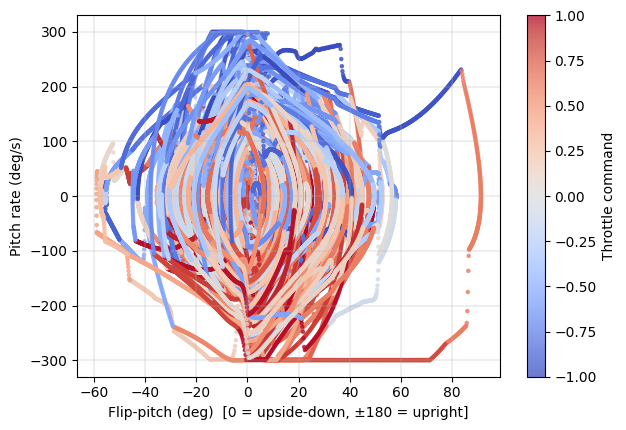

In [68]:
# Random actions with pitch-rate logging; 2D scatter (X=pitch, Y=pitch rate, color=throttle)

import math, numpy as np, matplotlib.pyplot as plt
from matplotlib.colors import TwoSlopeNorm
import mujoco as mj

# ---- config ----
CTRL_DT    = 0.05           # throttle update period [s] -> ~33.3 Hz
TOTAL_TIME =100.0           # total sim time [s]
U_MIN, U_MAX = -1.0, 1.0
SEED = 0
rng = np.random.default_rng(SEED)

# ---- model/data ----
#m = mj.MjModel.from_xml_path(str(xml_path))
m = mj.MjModel.from_xml_path(file_name)
d = mj.MjData(m)
mj.mj_resetData(m, d); mj.mj_forward(m, d)
d.ctrl[:] = 0.0

sim_dt_times = []

sim_dt = float(m.opt.timestep)
steps_per_cmd = max(1, int(round(CTRL_DT / sim_dt)))
num_cmds = int(TOTAL_TIME / CTRL_DT)

# indices
free_j = next(j for j in range(m.njnt) if m.jnt_type[j] == mj.mjtJoint.mjJNT_FREE)
qadr   = m.jnt_qposadr[free_j] + 3
bid    = mj.mj_name2id(m, mj.mjtObj.mjOBJ_BODY, "chassis")

# ---- run & log (uniform random throttle in [-1, 1]) ----
pitch_deg_log = []
omega_deg_s_log = []
throttle_log = []
height_z_log = []

prev_pitch = None
omega_1 = 0.0
ctrl_steps = 4
for k in range(num_cmds):
    sim_dt_times.append(m.opt.timestep)
    if k % ctrl_steps == 0:    
        u = float(rng.uniform(U_MIN, U_MAX))  # <<< random action
        d.ctrl[:] = u
    for _ in range(steps_per_cmd):
        mj.mj_step(m, d)
        qw, qx, qy, qz = d.qpos[qadr:qadr+4]
        pitch = ud_pitch_deg_from_quat(qw, qx, qy, qz, roof_is_neg_z=True)
        if prev_pitch is None:
            omega = 0.0
        else:
            # wrapped finite-difference (deg/s)
            dp = ((pitch - prev_pitch + 180.0) % 360.0) - 180.0
            omega = dp / sim_dt

            if omega > 300 or omega < -300:
                omega = omega_1

        omega_1 = omega

        prev_pitch = pitch

        pitch_deg_log.append(pitch)
        omega_deg_s_log.append(omega)
        throttle_log.append(u)
        height_z_log.append(d.xipos[3*bid + 2])   # chassis COM height (m)

pitch_deg_log   = np.asarray(pitch_deg_log)
omega_deg_s_log = np.asarray(omega_deg_s_log)
throttle_log    = np.asarray(throttle_log)
height_z_log    = np.asarray(height_z_log)

# ---- 2D scatter: X=pitch, Y=pitch rate, color=throttle ----
norm = TwoSlopeNorm(vmin=U_MIN, vcenter=0.0, vmax=U_MAX)
plt.figure(figsize=(6.4,4.4))
sc = plt.scatter(pitch_deg_log, omega_deg_s_log, c=throttle_log, s=5, alpha=0.75,
                 cmap='coolwarm', norm=norm)
plt.xlabel("Flip-pitch (deg)  [0 = upside-down, ±180 = upright]")
plt.ylabel("Pitch rate (deg/s)")
cbar = plt.colorbar(sc); cbar.set_label("Throttle command")
plt.grid(True, linewidth=0.3); plt.tight_layout(); plt.show()


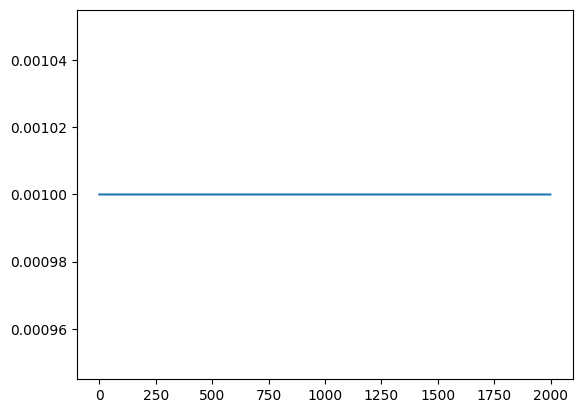

In [69]:
plt.plot(sim_dt_times)

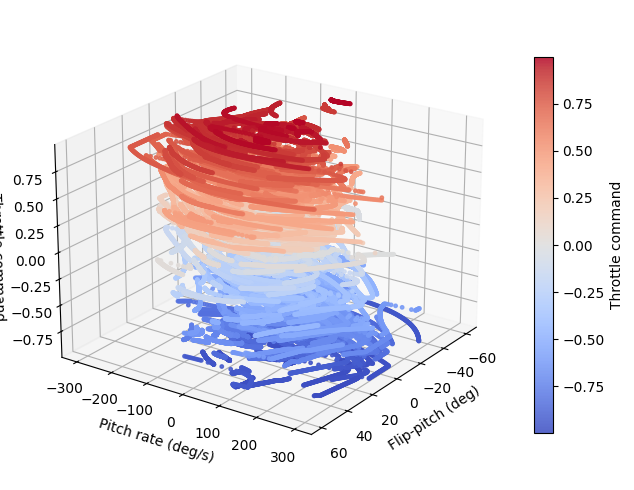

In [44]:
# 3D scatter: X = pitch (deg), Y = pitch rate (deg/s), Z = throttle; color = throttle
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import TwoSlopeNorm

pit   = np.asarray(pitch_deg_log)
rate  = np.asarray(omega_deg_s_log)
thr   = np.asarray(throttle_log)

fig = plt.figure(figsize=(7,5))
ax = fig.add_subplot(111, projection='3d')

norm = TwoSlopeNorm(vmin=thr.min(), vcenter=0.0, vmax=thr.max())
sc = ax.scatter(pit, rate, thr, c=thr, s=6, alpha=0.85, cmap='coolwarm', norm=norm)

ax.set_xlabel("Flip-pitch (deg)")
ax.set_ylabel("Pitch rate (deg/s)")
ax.set_zlabel("Throttle command")
ax.set_zlim(thr.min(), thr.max())
fig.colorbar(sc, ax=ax, shrink=0.8, pad=0.05, label="Throttle command")

ax.view_init(elev=22, azim=35)
plt.tight_layout()
plt.show()


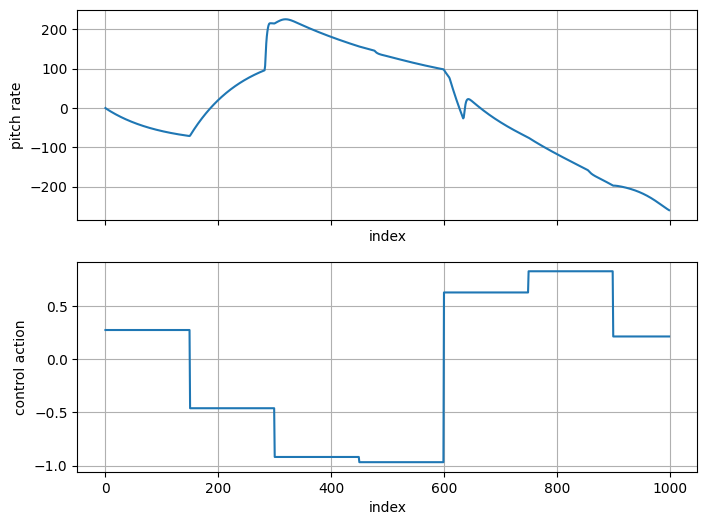

In [46]:
import numpy as np
import matplotlib.pyplot as plt

data_end = 1000

y = np.asarray(omega_deg_s_log[0:data_end])
dy = np.diff(y)
thr_2 = thr[0:data_end]
dth = np.diff(thr_2)

fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, sharex=True, figsize=(8, 6))        # 2D axes
ax1.plot(y)
ax1.set_xlabel("index")
ax1.set_ylabel("pitch rate")
ax1.grid()


ax2.plot(thr_2)
ax2.set_xlabel("index")
ax2.set_ylabel("control action")

plt.grid()
plt.show()



In [33]:
dy.shape

(999,)

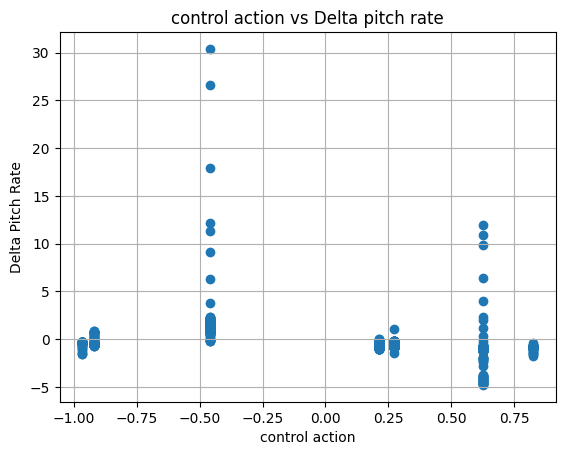

In [49]:
plt.scatter(thr_2[:-1], dy)
plt.xlabel("control action")
plt.ylabel("Delta Pitch Rate")
plt.title("control action vs Delta pitch rate")
plt.grid()

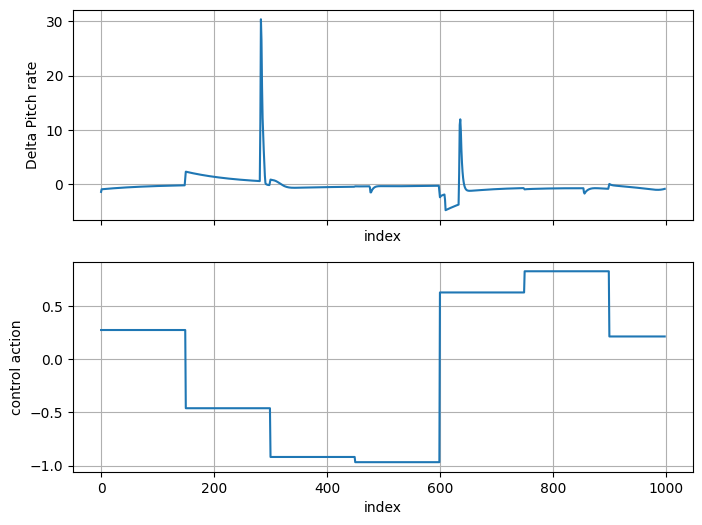

In [50]:
fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, sharex=True, figsize=(8, 6))        # 2D axes
ax1.plot(dy)
ax1.set_xlabel("index")
ax1.set_ylabel("Delta Pitch rate")
ax1.grid()


ax2.plot(thr_2[:-1])
ax2.set_xlabel("index")
ax2.set_ylabel("control action")

plt.grid()
plt.show()

# Gaussian Process Dyanmics

In [52]:
import torch
import gpytorch
import numpy as np

# ============================================================
# ---- Base Exact GP model -------------------
# ============================================================

class ExactGPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood, kernel='RBF', ard_dims=None):
        super().__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.ConstantMean()

        # Choose kernel type
        if kernel == 'RBF':
            base_kernel = gpytorch.kernels.RBFKernel(ard_num_dims=ard_dims)
        elif kernel == 'Matern':
            base_kernel = gpytorch.kernels.MaternKernel(nu=2.5, ard_num_dims=ard_dims)
        elif kernel == 'RQ':
            base_kernel = gpytorch.kernels.RationalQuadraticKernel(ard_num_dims=ard_dims)
        else:
            raise ValueError(f"Unsupported kernel type: {kernel}")

        self.covar_module = gpytorch.kernels.ScaleKernel(base_kernel)

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)


# ============================================================
# ---- Individual GP Manager: handles data + normalization ----
# ============================================================

class GPManager:
    def __init__(self, kernel='RBF', lr=0.03, iters=1000):
        self.kernel = kernel
        self.lr = lr
        self.iters = iters
        self.trained = False
        self.X_train = []
        self.Y_train = []

        self.likelihood = None
        self.model = None


    # ----------------------------- #
    #        FIT / INITIAL TRAIN    #
    # ----------------------------- #
    def fit(self, X, Y):
        X = torch.tensor(X, dtype=torch.float32)
        Y = torch.tensor(Y, dtype=torch.float32)

        self.X_train = X.clone()
        self.Y_train = Y.clone()

        self.retrain()

    def retrain(self):
        # Normalize the input/output and then train the model
        self._compute_normalization()
        self._train_model()

    # ----------------------------- #
    #       ADD NEW DATA POINTS     #
    # ----------------------------- #
    def add_data(self, X_new, Y_new, retrain=True):
        """
        Add new data (single or batch) to GP training set.
        Optionally retrain the model.
        """
        X_new = torch.tensor(X_new, dtype=torch.float32)
        Y_new = torch.tensor(Y_new, dtype=torch.float32).flatten()  # ensure 1D

        # Also flatten stored Y to ensure shape consistency
        if self.Y_train.ndim > 1:
            self.Y_train = self.Y_train.flatten()

        # Append new data
        self.X_train = torch.cat([self.X_train, X_new], dim=0)
        self.Y_train = torch.cat([self.Y_train, Y_new], dim=0)

        if retrain:
            self.retrain()

    # ----------------------------- #
    #         INTERNAL UTILS        #
    # ----------------------------- #
    def _compute_normalization(self):
        self.X_mean, self.X_std = self.X_train.mean(0), self.X_train.std(0)
        self.Y_mean, self.Y_std = float(self.Y_train.mean(0)), float(self.Y_train.std(0))

        Xn = (self.X_train - self.X_mean) / self.X_std
        Yn = (self.Y_train - self.Y_mean) / self.Y_std

        self.Xn, self.Yn = Xn, Yn

    def dataset(self):
        # Extract training data (already stored inside the wrapper)
        X_train = self.X_train.numpy()
        Y_train = self.Y_train.numpy()
        return X_train, Y_train


    def _train_model(self):
        self.likelihood = gpytorch.likelihoods.GaussianLikelihood()
        self.likelihood.noise_covar.initialize(noise=1e-3)
        self.model = ExactGPModel(self.Xn, self.Yn, self.likelihood,
                                  kernel=self.kernel, ard_dims=self.X_train.shape[-1])

        # -------------------------------------------------
        # Train the model
        # -------------------------------------------------
        self.train_gp(self.model, self.likelihood, self.Xn, self.Yn)
        self.trained = True

    def train_gp(self, model, likelihood, x, y):
        model.train(); likelihood.train()
        opt = torch.optim.Adam(model.parameters(), lr=self.lr)
        mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)
        for _ in range(self.iters):
            opt.zero_grad()
            out = model(x)
            loss = -mll(out, y)
            loss.backward()
            opt.step()
        model.eval(); likelihood.eval()

    def predict(self, X):
        if not self.trained:
            raise RuntimeError("GP has not been trained yet.")

        # Normalize the input
        X = torch.as_tensor(X, dtype=torch.float32)
        Xn = (X - self.X_mean) / self.X_std
        with torch.no_grad(), gpytorch.settings.fast_pred_var():
            pred = self.likelihood(self.model(Xn))

            # Unonormalize the output
            mean = pred.mean.cpu().numpy() * self.Y_std + self.Y_mean
            var = pred.variance.cpu().numpy() * (self.Y_std ** 2)
        # Return the unnormalized output
        return mean, var

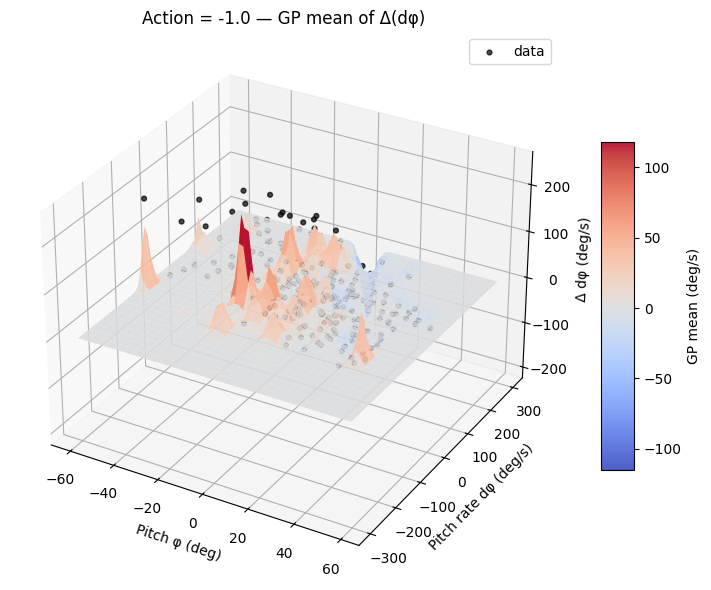

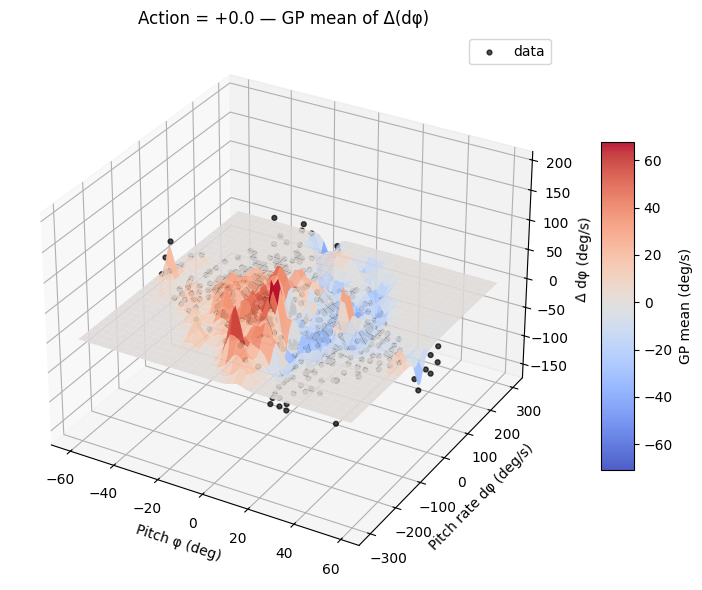

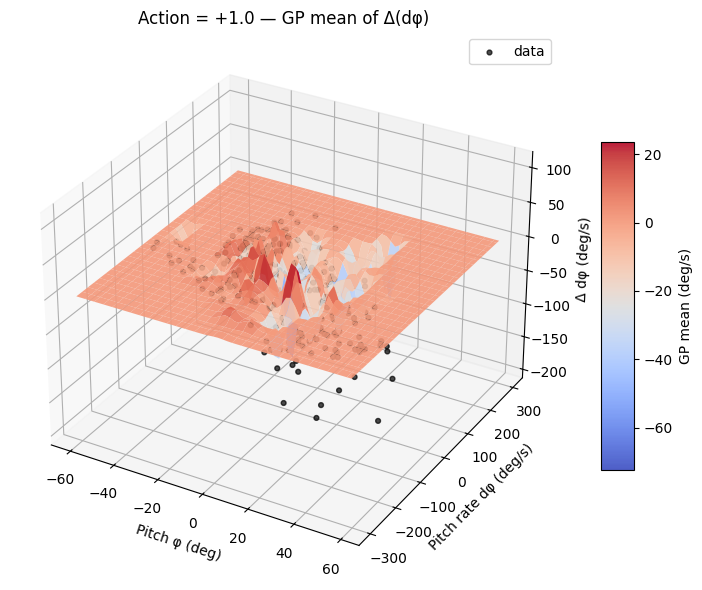

In [54]:
# === Train GP on MuJoCo logs and plot MC-style surfaces (φ vs dφ, fixed u) ===
import numpy as np, torch, matplotlib.pyplot as plt

# assumes your ExactGPModel + GPManager classes are already defined

# ----- Build control-rate dataset from logs -----
RAD2DEG = 180.0/np.pi
phi   = np.deg2rad(np.asarray(pitch_deg_log,   float))   # flip-pitch [rad]
dphi  = np.deg2rad(np.asarray(omega_deg_s_log, float))   # pitch rate [rad/s]
u     = np.asarray(throttle_log, float)

s = steps_per_cmd                      # subsample once per control command
phi_c, dphi_c, u_c = phi[::s], dphi[::s], u[::s]

# Inputs X = [sinφ, cosφ, dφ, u], Target Y = Δ(dφ) over one control step
# X = np.column_stack([phi_c[:-1], dphi_c[:-1], u_c[:-1]]) #np.column_stack([np.sin(phi_c[:-1]), np.cos(phi_c[:-1]), dphi_c[:-1], u_c[:-1]])
X = np.column_stack([np.sin(phi_c[:-1]), np.cos(phi_c[:-1]), dphi_c[:-1], u_c[:-1]])
Y = dphi_c[1:] - dphi_c[:-1]

# ----- Train GP -----
gpm = GPManager(kernel='RBF', lr=0.05, iters=800)
gpm.fit(X, Y)

# ----- MC-style visualization: surfaces at fixed actions -----
gp = gpm
Xtr, Ytr = gp.dataset()                       # raw (unnormalized) train data
sinp, cosp, dphi_tr, act_tr = Xtr[:,0], Xtr[:,1], Xtr[:,2], Xtr[:,3]
phi_tr = np.arctan2(sinp, cosp)

# grid over (φ, dφ)
p_min, p_max = phi_tr.min(), phi_tr.max()
v_min, v_max = dphi_tr.min(), dphi_tr.max()
p_grid = np.linspace(p_min, p_max, 60)
v_grid = np.linspace(v_min, v_max, 60)
P, V = np.meshgrid(p_grid, v_grid)

for a_fixed in (-1.0, 0.0, 1.0):
    X_grid = np.column_stack([
        np.sin(P.ravel()), np.cos(P.ravel()),
        V.ravel(), np.full(P.size, a_fixed, dtype=np.float32)
    ])
    Mean, Var = gp.predict(X_grid)                 # Δ(dφ) [rad/s]
    Mean = Mean.reshape(P.shape)

    fig = plt.figure(figsize=(9,6))
    ax = fig.add_subplot(111, projection='3d')
    surf = ax.plot_surface(P*RAD2DEG, V*RAD2DEG, Mean*RAD2DEG,
                           cmap='coolwarm', linewidth=0, antialiased=True, alpha=0.9)

    # overlay nearby training points for this action
    mask = np.abs(act_tr - a_fixed) < 0.25
    ax.scatter(phi_tr[mask]*RAD2DEG, dphi_tr[mask]*RAD2DEG, Ytr[mask]*RAD2DEG,
               color='k', s=12, alpha=0.7, label='data')

    ax.set_xlabel('Pitch φ (deg)')
    ax.set_ylabel('Pitch rate dφ (deg/s)')
    ax.set_zlabel('Δ dφ (deg/s)')
    ax.set_title(f'Action = {a_fixed:+.1f} — GP mean of Δ(dφ)')
    fig.colorbar(surf, ax=ax, shrink=0.6, aspect=10, label='GP mean (deg/s)')
    ax.legend()
    plt.tight_layout(); plt.show()


(2000,)

In [ ]:
pitch_deg_log.shape

Values near action a=-1.0 → n=261


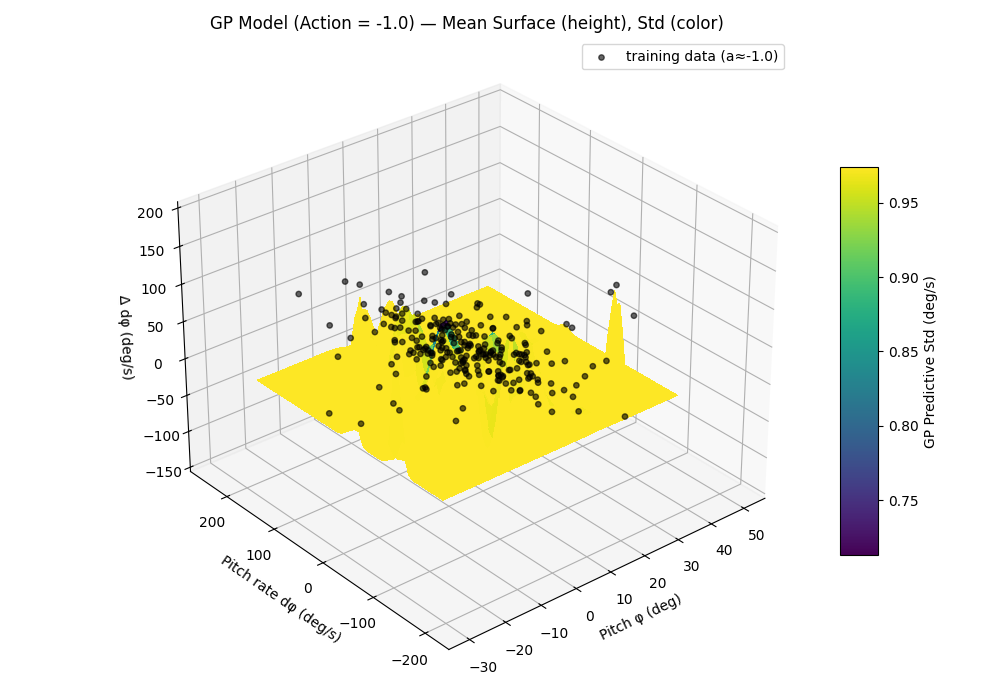

In [92]:
# 3D GP surface: Mean as height, Std as color (fixed action) — MuJoCo flip model
import numpy as np, torch, matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401

# assumes your GP was trained with inputs X=[sin(phi), cos(phi), dphi, u]
# and target Y = Δ(dphi) (rad/s) using GPManager -> instance `gpm`
gp = gpm
RAD2DEG = 180.0 / np.pi

# -------- training data (for overlay) --------
X_train, Y_train = gp.dataset()              # unnormalized, as stored by GPManager
sinp, cosp = X_train[:, 0], X_train[:, 1]
dphi_tr    = X_train[:, 2]                   # rad/s
act_tr     = X_train[:, 3]
phi_tr     = np.arctan2(sinp, cosp)          # rad
dvel_tr    = Y_train                         # Δ(dphi) target (rad/s)

# -------- choose fixed action & nearby samples for overlay --------
a_fixed = -1.0
mask = np.abs(act_tr - a_fixed) < 0.25
print(f"Values near action a={a_fixed} → n={int(mask.sum())}")

# -------- grid over (phi, dphi) --------
p_min, p_max = np.quantile(phi_tr, [0.01, 0.99])
v_min, v_max = np.quantile(dphi_tr, [0.01, 0.99])
p_grid = np.linspace(p_min, p_max, 80)
v_grid = np.linspace(v_min, v_max, 80)
P, V = np.meshgrid(p_grid, v_grid)

# -------- GP predictions on grid (fix action) --------
X_grid = np.column_stack([np.sin(P.ravel()), np.cos(P.ravel()),
                          V.ravel(), np.full(P.size, a_fixed, dtype=np.float32)])
Mean, Var = gp.predict(X_grid)               # Mean, Var in (rad/s)
Mean = Mean.reshape(P.shape)
Std  = np.sqrt(Var.reshape(P.shape))

# -------- color by predictive Std --------
norm = plt.Normalize(vmin=Std.min(), vmax=Std.max())
colors = plt.cm.viridis(norm(Std))

# -------- plot: Mean surface (height), Std (face color) --------
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')
surf = ax.plot_surface(P * RAD2DEG,              # φ in deg
                       V * RAD2DEG,              # dφ in deg/s
                       Mean * RAD2DEG,           # Δ(dφ) in deg/s
                       facecolors=colors,
                       linewidth=0, antialiased=False, shade=False)

# colorbar for Std (deg/s)
m = plt.cm.ScalarMappable(cmap='viridis', norm=norm)
m.set_array(Std * RAD2DEG)
cbar = fig.colorbar(m, ax=ax, shrink=0.6, aspect=10)
cbar.set_label('GP Predictive Std (deg/s)')

# overlay training points near the fixed action
ax.scatter(phi_tr[mask] * RAD2DEG,
           dphi_tr[mask] * RAD2DEG,
           dvel_tr[mask] * RAD2DEG,
           color='k', s=15, alpha=0.6, label=f'training data (a≈{a_fixed:+.1f})')

# labels
ax.set_xlabel('Pitch φ (deg)')
ax.set_ylabel('Pitch rate dφ (deg/s)')
ax.set_zlabel('Δ dφ (deg/s)')
ax.set_title(f"GP Model (Action = {a_fixed:+.1f}) — Mean Surface (height), Std (color)")
ax.view_init(elev=30, azim=230)
ax.legend()
plt.tight_layout()
plt.show()


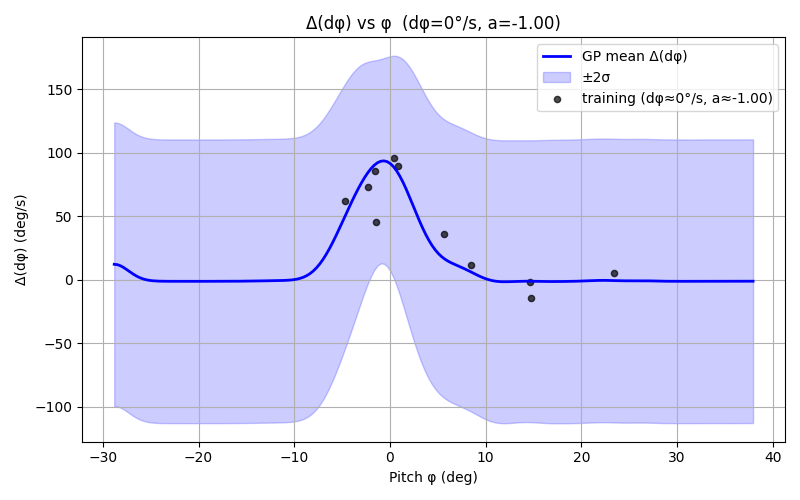

In [93]:
# 1D GP slice for MuJoCo car: Δ(dφ) vs φ at fixed (dφ, u)
# Uses GP trained with X=[sinφ, cosφ, dφ, u], Y=Δ(dφ) (rad/s)

import numpy as np
import matplotlib.pyplot as plt

gp = gpm  # your GPManager instance trained on MuJoCo data
RAD2DEG = 180.0 / np.pi

# Training data (for overlay)
X_train, Y_train = gp.dataset()               # X=[sinφ, cosφ, dφ, u], Y=Δ(dφ)
sinp, cosp = X_train[:, 0], X_train[:, 1]
dphi_tr     = X_train[:, 2]                   # rad/s
act_tr      = X_train[:, 3]
phi_tr      = np.arctan2(sinp, cosp)          # rad

# Fixed slice settings
a_fixed = -1.0             # throttle slice (continuous)
dphi_fixed_deg_s = 0.0     # pitch-rate slice in deg/s (for readability)
dphi_fixed = np.deg2rad(dphi_fixed_deg_s)

# φ grid (within training support)
phi_min, phi_max = np.quantile(phi_tr, [0.01, 0.99])
phi_grid = np.linspace(phi_min, phi_max, 200)

# Query GP on the slice
X_query = np.column_stack([
    np.sin(phi_grid), np.cos(phi_grid),
    np.full_like(phi_grid, dphi_fixed),
    np.full_like(phi_grid, a_fixed, dtype=np.float32)
])
Mean, Var = gp.predict(X_query)   # rad/s
Std = np.sqrt(Var)

# Plot mean ± 2σ
plt.figure(figsize=(8,5))
plt.plot(phi_grid*RAD2DEG, Mean*RAD2DEG, 'b-', lw=2, label='GP mean Δ(dφ)')
plt.fill_between(phi_grid*RAD2DEG,
                 (Mean-2*Std)*RAD2DEG, (Mean+2*Std)*RAD2DEG,
                 color='blue', alpha=0.2, label='±2σ')

# Overlay training points near this slice
mask = (np.abs(dphi_tr - dphi_fixed) < np.deg2rad(5.0)) & (np.abs(act_tr - a_fixed) < 0.25)
plt.scatter(phi_tr[mask]*RAD2DEG, Y_train[mask]*RAD2DEG,
            color='k', s=20, alpha=0.7,
            label=f'training (dφ≈{dphi_fixed_deg_s:.0f}°/s, a≈{a_fixed:+.2f})')

plt.xlabel('Pitch φ (deg)')
plt.ylabel('Δ(dφ) (deg/s)')
plt.title(f'Δ(dφ) vs φ  (dφ={dphi_fixed_deg_s:.0f}°/s, a={a_fixed:+.2f})')
plt.grid(True); plt.legend(); plt.tight_layout(); plt.show()


# MPPI CONTROLLER FOR TRAINING 

In [82]:
# MPPI-for-training: config + imports

import numpy as np, math, collections
import mujoco as mj
import matplotlib.pyplot as plt

# -------- MPPI / data collection knobs --------
H         = 25            # horizon (control steps)
K         = 256           # sampled trajectories
LAM       = 0.5           # MPPI temperature (higher => flatter weights)
ACT_SIGMA = 0.5           # throttle noise std for sampling
U_MIN, U_MAX = -1.0, 1.0  # throttle bounds
RETRAIN_EVERY   = 60      # retrain GP every N control steps
MAX_CTRL_STEPS  = 12000     # total control steps for this run
CTRL_DT         = 0.05    # control interval (s). Must match GP target definition.

SEED = 0
rng  = np.random.default_rng(SEED)
RAD2DEG = 180.0/np.pi

# NOTE: you must already have a warm-start GPManager instance named `gpm`,
# trained on at least a tiny dataset, with inputs X=[sinφ, cosφ, dφ, u] and target Y=Δ(dφ).
assert 'gpm' in globals() and getattr(gpm, 'trained', False), "Warm-start `gpm` before running."


In [83]:
# Load MuJoCo model, set control rate, and define state readers

# Resolve XML path (use your existing `xml_path` if defined, else fallback)
try:
    XML = str(xml_path)
except NameError:
    XML = "monstertruck.xml"

m = mj.MjModel.from_xml_path(XML)
d = mj.MjData(m)
mj.mj_resetData(m, d); mj.mj_forward(m, d)
d.ctrl[:] = 0.0

sim_dt       = float(m.opt.timestep)
steps_per_cmd = max(1, int(round(CTRL_DT / sim_dt)))
dt_ctrl       = steps_per_cmd * sim_dt

# indices
free_j = next(j for j in range(m.njnt) if m.jnt_type[j] == mj.mjtJoint.mjJNT_FREE)
qadr   = m.jnt_qposadr[free_j] + 3
dof0   = m.jnt_dofadr[free_j]
bid    = mj.mj_name2id(m, mj.mjtObj.mjOBJ_BODY, "chassis")

def flip_pitch_rad_from_quat(qw, qx, qy, qz, roof_is_neg_z=True):
    # rotation matrix (body->world)
    R00 = 1 - 2*(qy*qy + qz*qz);  R01 = 2*(qx*qy - qw*qz);  R02 = 2*(qx*qz + qw*qy)
    R10 = 2*(qx*qy + qw*qz);      R11 = 1 - 2*(qx*qx + qz*qz); R12 = 2*(qy*qz - qw*qx)
    R20 = 2*(qx*qz - qw*qy);      R21 = 2*(qy*qz + qw*qx);  R22 = 1 - 2*(qx*qx + qy*qy)
    y_w = (R01, R11, R21); z_body_w = (R02, R12, R22)
    r_w = (-z_body_w[0], -z_body_w[1], -z_body_w[2]) if roof_is_neg_z else z_body_w
    vx, vy = (-r_w[1], r_w[0])        # z×r with z=(0,0,1)
    vnorm  = math.hypot(vx, vy)
    c      = max(-1.0, min(1.0, r_w[2]))
    theta  = math.atan2(vnorm, c)     # [0, π]
    s_axis = vx*y_w[0] + vy*y_w[1]    # sign about pitch axis
    sgn    = 1.0 if s_axis >= 0.0 else -1.0
    phi    = sgn * theta              # [-π, π]
    return phi

def read_state():
    # φ from quaternion
    qw,qx,qy,qz = d.qpos[qadr:qadr+4]
    phi = flip_pitch_rad_from_quat(qw,qx,qy,qz, roof_is_neg_z=True)
    # dφ from angular velocity projected on body +Y axis
    R = d.xmat[bid].reshape(3,3)
    y_w = R[:,1]
    w_world = d.qvel[dof0+3:dof0+6]
    dphi = float(np.dot(w_world, y_w))  # rad/s
    # wrap φ
    if phi >  np.pi: phi -= 2*np.pi
    if phi <= -np.pi: phi += 2*np.pi
    return float(phi), float(dphi)


In [84]:
# Force eval mode + safe normalization inside GPManager.predict

import torch, gpytorch
import numpy as np

def _predict_safe(self, X):
    if not getattr(self, "trained", False):
        raise RuntimeError("GP has not been trained yet.")

    # Ensure eval mode every time
    self.model.eval()
    self.likelihood.eval()

    # Device-safe tensors
    dev = next(self.model.parameters()).device
    X = torch.as_tensor(X, dtype=torch.float32, device=dev)

    # Guard against tiny std
    eps = 1e-8
    Xn = (X - self.X_mean.to(dev)) / (self.X_std.to(dev) + eps)

    with torch.no_grad(), gpytorch.settings.fast_pred_var(), gpytorch.settings.debug(False):
        pred = self.likelihood(self.model(Xn))

    mean = pred.mean.detach().cpu().numpy() * (float(self.Y_std) if np.isscalar(self.Y_std) else float(self.Y_std))
    var  = pred.variance.detach().cpu().numpy() * (float(self.Y_std) if np.isscalar(self.Y_std) else float(self.Y_std))**2
    return mean, var

# Monkey-patch the method
GPManager.predict = _predict_safe
print("Patched GPManager.predict to force eval mode and safe normalization.")


Patched GPManager.predict to force eval mode and safe normalization.


In [85]:
# One prediction to verify everything works before MPPI
phi0, dphi0 = read_state()
X_test = np.array([[np.sin(phi0), np.cos(phi0), dphi0, 0.0]], dtype=np.float32)
mu, var = gpm.predict(X_test)
print("Test predict OK. μ, σ:", float(mu[0]), float(np.sqrt(var[0])))


Test predict OK. μ, σ: 0.1290920227766037 0.8896715641021729


In [94]:
# ---------- cost: uncertainty-seeking (minimize to seek high variance) ----------
# J_t = -σ_t^2 + u_reg * u_t^2  (optionally discounted by gamma^t)
def cost_fn(var_t, u_t=None, *, u_reg=0.0, gamma=1.0, t=0):
    """
    var_t : (K,) predictive variance at step t from the GP      [ (Δdφ)^2 ]
    u_t   : (K,) throttle at step t (optional action penalty)
    u_reg : nonnegative scalar; action regularization weight
    gamma : discount factor in (0, 1]; 1.0 = no discount
    t     : step index used only for discounting

    Returns: elementwise cost (K,), more negative = more uncertain (preferred)
    """
    c = -var_t
    if u_t is not None and u_reg > 0.0:
        c = c + u_reg * (u_t**2)
    if gamma != 1.0:
        c = (gamma**t) * c
    return c.astype(np.float32)

In [95]:
# ---------- MPPI planner (cost-form). Minimizes J; still explores uncertainty ----------
def mppi_plan(phi0, dphi0, u_seq, gpm, K, H, lam, sigma):
    
    u_reg=0.0

    gamma=1.0
    
    # sample noise around nominal plan
    eps = rng.normal(0.0, sigma, size=(K, H)).astype(np.float32)
    Uc  = np.clip(u_seq[np.newaxis, :] + eps, U_MIN, U_MAX)

    # rollouts under GP model
    phi  = np.full(K, phi0, dtype=np.float32)
    dphi = np.full(K, dphi0, dtype=np.float32)
    J    = np.zeros(K, dtype=np.float32)     # accumulated *cost*
    Racc = np.zeros(K, dtype=np.float32)     # accumulated variance (for logging)

    for t in range(H):
        u_t = Uc[:, t]
        X = np.column_stack([np.sin(phi), np.cos(phi), dphi, u_t]).astype(np.float32)
        mu, var = gpm.predict(X)                 # mu: Δdφ,  var: (Δdφ)^2
        var = var.astype(np.float32)

        # integrate simple GP dynamics
        dphi = dphi + mu.astype(np.float32)
        phi  = phi  + dphi * dt_ctrl
        phi  = ((phi + np.pi) % (2*np.pi)) - np.pi

        # accumulate cost (negative variance => uncertainty-seeking)
        J    += cost_fn(var, u_t, u_reg=u_reg, gamma=gamma, t=t)
        Racc += var

    # MPPI weights for *cost*: lower J gets higher weight
    Jmin = J.min()
    w = np.exp(-(J - Jmin) / max(1e-6, lam)).astype(np.float64)
    w /= (w.sum() + 1e-12)

    du = (w[:, None] * eps).sum(axis=0)           # weighted noise update
    u_new = np.clip(u_seq + du, U_MIN, U_MAX)

    # diagnostic: weighted average accumulated uncertainty of the chosen plan
    Ubar = float(np.sum(w * Racc))
    return u_new, Ubar

In [96]:
# Fixed validation split from current GP data + metric helpers

# Freeze a small validation set from current GP data (stays constant across retrains)
X0, Y0 = gpm.dataset()
perm = np.random.default_rng(0).permutation(len(Y0))
nval = min(500, max(100, int(0.2*len(Y0))))
X_val = X0[perm[:nval]]
Y_val = Y0[perm[:nval]]

metrics = {"step": [], "N_train": [], "rmse": [], "nlpd": [], "avg_std_grid": [], "Jbar_recent": []}
Jhist = collections.deque(maxlen=200)

# Patch: robust metrics (flatten arrays; mean before float)
import numpy as np

def eval_on_val(gp):
    mu, var = gp.predict(X_val)
    mu  = np.asarray(mu).reshape(-1)
    var = np.asarray(var).reshape(-1)
    y   = np.asarray(Y_val).reshape(-1)

    rmse = float(np.sqrt(np.mean((mu - y)**2)))

    var_c = np.clip(var, 1e-9, None)
    nlpd_arr = 0.5*np.log(2*np.pi*var_c) + 0.5*((y - mu)**2)/var_c
    nlpd = float(np.mean(nlpd_arr))
    return rmse, nlpd

def avg_std_on_grid(gp, u_fixed=0.0, n_phi=40, n_dphi=40):
    sinp, cosp, dphi_tr = X_val[:,0], X_val[:,1], X_val[:,2]
    phi_tr = np.arctan2(sinp, cosp)
    pmin, pmax = np.quantile(phi_tr,  [0.01, 0.99])
    vmin, vmax = np.quantile(dphi_tr, [0.01, 0.99])
    P = np.linspace(pmin, pmax, n_phi)
    V = np.linspace(vmin, vmax, n_dphi)
    PP, VV = np.meshgrid(P, V)
    Xg = np.column_stack([np.sin(PP.ravel()), np.cos(PP.ravel()), VV.ravel(),
                          np.full(PP.size, u_fixed, dtype=np.float32)])
    _, var = gp.predict(Xg)
    var = np.asarray(var).reshape(-1)
    return float(np.mean(np.sqrt(np.clip(var, 1e-9, None))))


In [ ]:
# Main MPPI-for-training loop
u_seq = np.zeros(H, dtype=np.float32)   # initial nominal plan
X_buf, Y_buf = [], []

for step in range(1, MAX_CTRL_STEPS+1):
    # read state at control boundary
    phi0, dphi0 = read_state()

    # plan with MPPI (pass ACT_SIGMA each time so decay works if you change it)
    u_seq, Jbar = mppi_plan(phi0, dphi0, u_seq, gpm, K=K, H=H, lam=LAM, sigma=ACT_SIGMA)
    Jhist.append(Jbar)

    # execute first action for one control interval
    u = float(u_seq[0])
    d.ctrl[:] = u
    # receding horizon shift
    u_seq[:-1] = u_seq[1:]
    u_seq[-1]  = u_seq[-2]

    # simulate one control interval
    for _ in range(steps_per_cmd):
        mj.mj_step(m, d)

    # log one-step sample at control rate
    _, dphi1 = read_state()
    X_buf.append([math.sin(phi0), math.cos(phi0), dphi0, u])
    Y_buf.append(dphi1 - dphi0)  # Δdφ (rad/s) over dt_ctrl

    # periodic retrain
    if step % RETRAIN_EVERY == 0:
        X_new = np.asarray(X_buf, dtype=np.float32)
        Y_new = np.asarray(Y_buf, dtype=np.float32)
        gpm.add_data(X_new, Y_new, retrain=True)
        X_buf.clear(); Y_buf.clear()

        # evaluate & log metrics
        rmse, nlpd = eval_on_val(gpm)
        avg_std = avg_std_on_grid(gpm, u_fixed=0.0)
        metrics["step"].append(step)
        metrics["N_train"].append(int(gpm.X_train.shape[0]))
        metrics["rmse"].append(rmse)
        metrics["nlpd"].append(nlpd)
        metrics["avg_std_grid"].append(avg_std)
        metrics["Jbar_recent"].append(float(np.mean(Jhist)) if len(Jhist) else np.nan)

        print(f"[retrain] step={step:4d}  N={metrics['N_train'][-1]:5d}  "
              f"RMSE={rmse*RAD2DEG:.4f} deg/s  NLPD={nlpd:.3f}  "
              f"avgσ(grid)={avg_std*RAD2DEG:.4f} deg/s  J̄_recent={metrics['Jbar_recent'][-1]:.4e}")


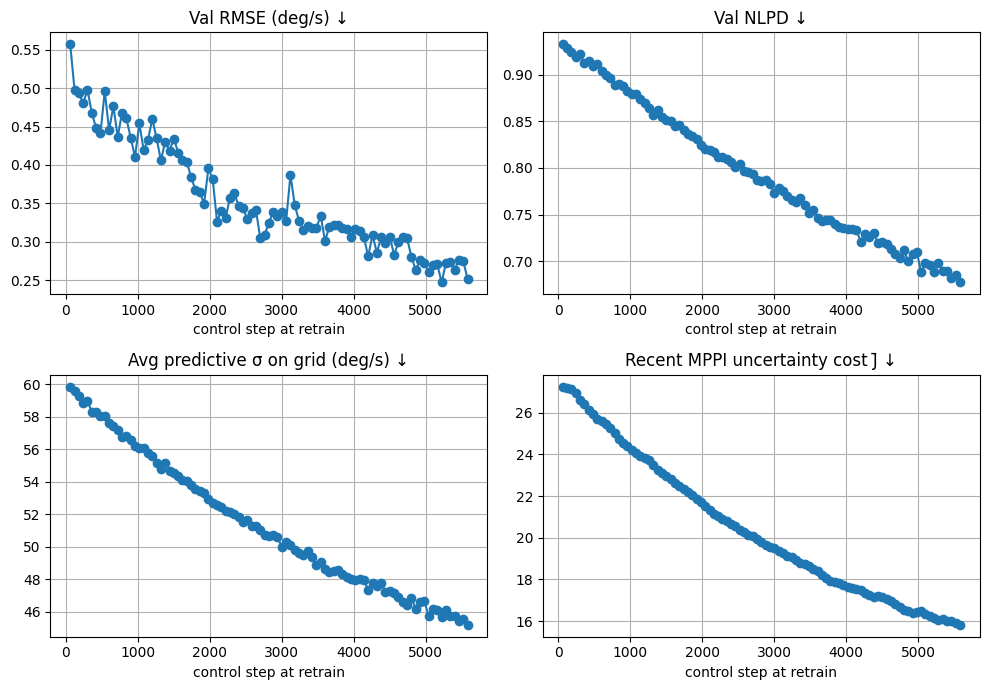

In [89]:
# Plot RMSE, NLPD, avg predictive std on grid, and recent MPPI cost

s    = np.array(metrics["step"]);     N = np.array(metrics["N_train"])
rmse = np.array(metrics["rmse"]) * RAD2DEG         # deg/s
nlpd = np.array(metrics["nlpd"])
stdg = np.array(metrics["avg_std_grid"]) * RAD2DEG # deg/s
Jbar = np.array(metrics["Jbar_recent"])

fig, axs = plt.subplots(2,2, figsize=(10,7))
axs[0,0].plot(s, rmse, marker='o'); axs[0,0].set_title("Val RMSE (deg/s) ↓"); axs[0,0].grid(True)
axs[0,1].plot(s, nlpd, marker='o'); axs[0,1].set_title("Val NLPD ↓");         axs[0,1].grid(True)
axs[1,0].plot(s, stdg, marker='o'); axs[1,0].set_title("Avg predictive σ on grid (deg/s) ↓"); axs[1,0].grid(True)
axs[1,1].plot(s, Jbar, marker='o'); axs[1,1].set_title("Recent MPPI uncertainty cost J̄ ↓");   axs[1,1].grid(True)

for ax in axs.ravel():
    ax.set_xlabel("control step at retrain")
plt.tight_layout(); plt.show()
